# Chat intents

## Initial Data Exploration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import re
import nltk
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.tokenize import WhitespaceTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("max_colwidth", 400)

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/dave/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/dave/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/dave/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Load data

In [3]:
data_full = pd.read_csv('../data/raw/train.csv')
data_full.sample(10)

,text,category
9473,What was the extra charge for withdrawing money?,cash_withdrawal_charge
8849,Please help me figure out the reason for the odd withdrawal amount from my account?,cash_withdrawal_not_recognised
2397,"I think something went wrong, I didn't get the right amount.",wrong_amount_of_cash_received
4274,"My wallet isn't showing my top-up, did I do something wrong?",topping_up_by_card
8399,How about disposable virtual cards?,get_disposable_virtual_card
6443,I have a duplicate payment on my account,transaction_charged_twice
391,I am travelling and I was wondering what your exchange rates are,exchange_rate
6708,what is the time frame for transfers,transfer_timing
7741,Where is my top-up verification code?,verify_top_up
9888,Which countries do you operate in,country_support


In [4]:
len(data_full)

10003

In [5]:
(data_full.category.value_counts()
                   .to_frame()
                   .reset_index()
                   .rename(columns={'index': 'intent', 'category': 'count'}))

,intent,count
0,card_payment_fee_charged,187
1,direct_debit_payment_not_recognised,182
2,balance_not_updated_after_cheque_or_cash_deposit,181
3,wrong_amount_of_cash_received,180
4,cash_withdrawal_charge,177
5,transaction_charged_twice,175
6,declined_cash_withdrawal,173
7,transfer_fee_charged,172
8,transfer_not_received_by_recipient,171
9,balance_not_updated_after_bank_transfer,171


In [6]:
data_full[data_full['category']=='card_swallowed']

,text,category
6245,What do I do if the ATM took my card?,card_swallowed
6246,What do I do now my credit card has been swallowed by the ATM?,card_swallowed
6247,An ATM machine didn't give me back my card.,card_swallowed
6248,"My card got trapped inside an ATM, what should I do?",card_swallowed
6249,What do I do if I can't get my card out of the ATM?,card_swallowed
6250,My card got stuck in an ATM.,card_swallowed
6251,Your machine took my card. How do I get it back?,card_swallowed
6252,"I can't get my card out of the ATM, what should I do now?",card_swallowed
6253,My card is stuck in the ATM?,card_swallowed
6254,I didn't get my card back from the ATM.,card_swallowed


Take a sample of the larger dataset to use for much of the analysis.

In [7]:
data_sample = data_full.sample(n=1000, random_state=123)

In [8]:
data_sample.category.value_counts()

Refund_not_showing_up                               26
cash_withdrawal_charge                              24
cancel_transfer                                     23
pending_card_payment                                23
transfer_not_received_by_recipient                  22
direct_debit_payment_not_recognised                 22
cash_withdrawal_not_recognised                      21
request_refund                                      21
verify_top_up                                       18
verify_source_of_funds                              18
balance_not_updated_after_cheque_or_cash_deposit    18
declined_card_payment                               17
wrong_amount_of_cash_received                       17
declined_cash_withdrawal                            17
wrong_exchange_rate_for_cash_withdrawal             17
card_payment_not_recognised                         17
visa_or_mastercard                                  17
transfer_fee_charged                                17
top_up_by_

### Clean data

In [9]:
stop_words = set(stopwords.words('english'))

print(stop_words)

{'same', 'itself', "you'd", "shouldn't", "it's", 'needn', 'will', "mustn't", 'wasn', 'nor', 'hadn', 'other', 'll', 'isn', 'and', "won't", 'down', 'myself', 'any', 'now', 'what', 'again', 'does', 'between', "didn't", 'where', 'shan', 'over', "needn't", 'yourselves', 'this', "couldn't", 'd', 'won', 'no', 'y', 'am', 'but', 'while', 't', 'those', 'hasn', 'once', 'about', 'had', 'because', 'has', 'wouldn', 'more', 'it', 'do', 'our', 'are', 'of', 'ourselves', 'be', "aren't", 'here', 'from', 'out', 'yourself', 'through', 've', "should've", "doesn't", "hadn't", 'you', 'didn', "hasn't", 'shouldn', 'before', 'how', 'so', "isn't", 'or', 'being', 'whom', "you'll", 'with', 'her', 'was', 'at', 'which', 'have', 'doing', 'ma', 'for', 'their', 'when', 'both', 'that', 'as', 'by', "wasn't", "wouldn't", 'can', 'hers', 'if', "don't", 'why', 'they', 'who', 'mightn', 'its', "weren't", 'too', 'don', 're', 's', "that'll", 'your', 'very', 'doesn', 'yours', 'above', 'ain', 'some', "she's", 'into', 'than', 'she',

In [21]:
def clean_text(text):
    """
    Summary: turns text input string into list of cleaned word tokens
    
    Arguments:
        text: str of text
    
    Returns:
        lemmatized_words: str, lemmatized words from original text after cleaning
    """
    
    # remove numbers
    clean_text = re.sub(r'[0-9]+', '', text)
    
    # remove punctuation
    clean_text = re.sub(r'[^\w\s]', '', clean_text)
    
    # convert everything to lowercase
    clean_text = clean_text.lower()
    
    # tokenize
    wt = WhitespaceTokenizer()
    words = wt.tokenize(clean_text)
    
    # remove stop words
    cleaned_words = []
    for w in words:
        if w not in stop_words:
            cleaned_words.append(w)
            
    # lemmatize words
    wnl = WordNetLemmatizer()
    wnl_lemmatized_tokens = []
    for token in cleaned_words:
        wnl_lemmatized_tokens.append(wnl.lemmatize(token))
    
    lemmatized_words = ' '.join(wnl_lemmatized_tokens)
    
    return lemmatized_words

In [22]:
data_sample['cleaned_text'] = data_sample['text'].apply(lambda x: clean_text(x))
data_sample.head()

,text,category,cleaned_text
1024,I'm worried my card might be lost in the mail? How long does it usually take to arrive?,card_delivery_estimate,im worried card might lost mail long usually take arrive
9405,I got charged a fee that shouldn't be there from my cash,cash_withdrawal_charge,got charged fee shouldnt cash
9368,Do you charge for making a withdrawal? I took some money out of my account earlier and I was charged for this.,cash_withdrawal_charge,charge making withdrawal took money account earlier charged
3414,Is there an issue with my account? I don't see a cheque deposit that I made yesterday. Please assist.,balance_not_updated_after_cheque_or_cash_deposit,issue account dont see cheque deposit made yesterday please assist
7402,Are there ways for other people to send me money?,receiving_money,way people send money


In [23]:
sample_text = ' '.join(list(data_sample['text'].values))
print(sample_text[0:400])

I'm worried my card might be lost in the mail? How long does it usually take to arrive? I got charged a fee that shouldn't be there from my cash Do you charge for making a withdrawal? I took some money out of my account earlier and I was charged for this. Is there an issue with my account?  I don't see a cheque deposit that I made yesterday.  Please assist. Are there ways for other people to send 


In [24]:
clean_sample_text = ' '.join(list(data_sample['cleaned_text'].values))
print(clean_sample_text[0:400])

im worried card might lost mail long usually take arrive got charged fee shouldnt cash charge making withdrawal took money account earlier charged issue account dont see cheque deposit made yesterday please assist way people send money receive money change address still received new card anywhere cant use card want multiple currency account possible wouldnt atm give cash business eu add people acc


### Word distributions across all messages in sample

In [25]:
# tokenize
wt = WhitespaceTokenizer()
clean_tokens = wt.tokenize(clean_sample_text)

freq_dist = FreqDist(clean_tokens)
print(freq_dist)

<FreqDist with 810 samples and 5351 outcomes>


In [26]:
freq_dist.most_common(500)

[('card', 282),
 ('account', 130),
 ('money', 110),
 ('transfer', 109),
 ('payment', 96),
 ('need', 75),
 ('cash', 73),
 ('get', 73),
 ('please', 67),
 ('top', 62),
 ('charged', 54),
 ('app', 51),
 ('fee', 50),
 ('atm', 50),
 ('help', 48),
 ('use', 47),
 ('refund', 45),
 ('pending', 44),
 ('long', 43),
 ('made', 43),
 ('exchange', 43),
 ('transaction', 42),
 ('topup', 42),
 ('currency', 39),
 ('would', 39),
 ('withdrawal', 38),
 ('take', 37),
 ('rate', 37),
 ('charge', 34),
 ('didnt', 34),
 ('still', 33),
 ('new', 33),
 ('time', 33),
 ('dont', 32),
 ('wrong', 32),
 ('like', 32),
 ('know', 31),
 ('make', 31),
 ('pin', 31),
 ('declined', 30),
 ('im', 28),
 ('working', 28),
 ('got', 27),
 ('see', 27),
 ('virtual', 27),
 ('tried', 27),
 ('want', 26),
 ('yet', 26),
 ('show', 25),
 ('using', 25),
 ('work', 24),
 ('bank', 24),
 ('cant', 23),
 ('cancel', 23),
 ('getting', 23),
 ('go', 23),
 ('tell', 22),
 ('check', 22),
 ('disposable', 22),
 ('one', 22),
 ('statement', 20),
 ('fund', 20),
 ('i

In [27]:
freq_dist.get('account')

130

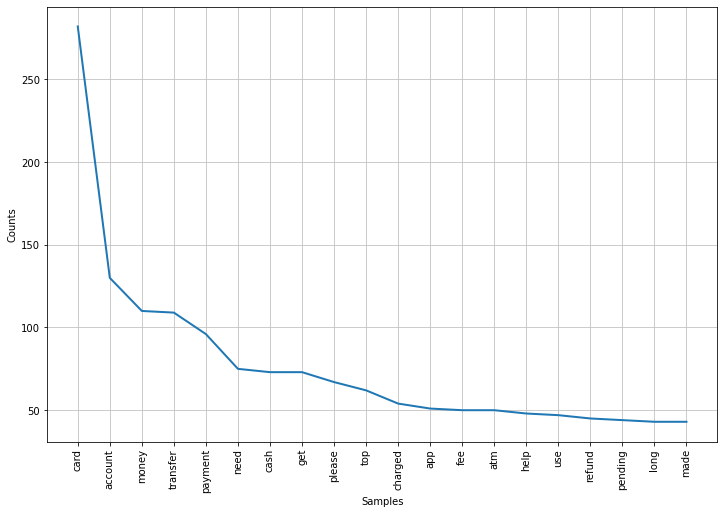

In [33]:
fig, ax = plt.subplots(figsize=(12,8))
freq_dist.plot(20, cumulative=False)
plt.show()

## Save cleaned data

In [36]:
data_sample.to_csv('../data/processed/data_sample.csv')